In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

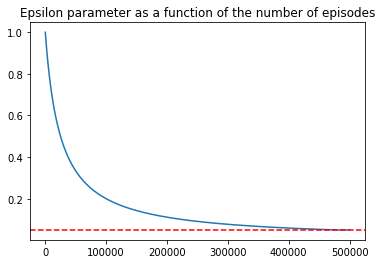

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 216
add_noise = False

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

#     else:
#         raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


#     ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

#     # Output headers to file
#     with open(rewards_file,'w') as f:
#          np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.07  minuts. epsilon 0.9961 Discounted reward:  -19.141380351033337
Episode: 200. Elapsed time  0.17  minuts. epsilon 0.9921 Discounted reward:  -18.196010755374154
Episode: 300. Elapsed time  0.29  minuts. epsilon 0.9882 Discounted reward:  -18.11736083831751
Episode: 400. Elapsed time  0.41  minuts. epsilon 0.9843 Discounted reward:  -15.954879957240015
Episode: 500. Elapsed time  0.55  minuts. epsilon 0.9804 Discounted reward:  -21.231536039882837
Episode: 600. Elapsed time  0.7  minuts. epsilon 0.9766 Discounted reward:  -19.96914955395108
Episode: 700. Elapsed time  0.87  minuts. epsilon 0.9728 Discounted reward:  -22.43848421141035
Episode: 800. Elapsed time  1.04  minuts. epsilon 0.969 Discounted reward:  -20.812974284319047
Episode: 900. Elapsed time  1.22  minuts. epsilon 0.9653 Discounted reward:  -15.486881357922996
Episode: 1000. Elapsed time  1.43  minuts. epsilon 0.9616 Discounted reward:  -20.710616293502575
Episode: 1100. Elapsed time  1.64 

Episode: 8500. Elapsed time  33.37  minuts. epsilon 0.7463 Discounted reward:  -18.139804926200135
Episode: 8600. Elapsed time  33.92  minuts. epsilon 0.7441 Discounted reward:  -7.989813472572647
Episode: 8700. Elapsed time  34.48  minuts. epsilon 0.7419 Discounted reward:  -9.135502764219002
Episode: 8800. Elapsed time  35.05  minuts. epsilon 0.7397 Discounted reward:  -14.312997889220657
Episode: 8900. Elapsed time  35.63  minuts. epsilon 0.7375 Discounted reward:  -8.705799184430258
Episode: 9000. Elapsed time  36.21  minuts. epsilon 0.7353 Discounted reward:  -22.050078028185045
Episode: 9100. Elapsed time  36.8  minuts. epsilon 0.7332 Discounted reward:  -12.09117009488273
Episode: 9200. Elapsed time  37.36  minuts. epsilon 0.731 Discounted reward:  -16.973726375352516
Episode: 9300. Elapsed time  37.93  minuts. epsilon 0.7289 Discounted reward:  -15.684381967615263
Episode: 9400. Elapsed time  38.51  minuts. epsilon 0.7268 Discounted reward:  -7.824984942038316
Episode: 9500. El

Episode: 16800. Elapsed time  87.69  minuts. epsilon 0.5981 Discounted reward:  -7.8056423941684905
Episode: 16900. Elapsed time  88.4  minuts. epsilon 0.5967 Discounted reward:  -6.009157318452108
Episode: 17000. Elapsed time  89.11  minuts. epsilon 0.5953 Discounted reward:  -15.407026217479324
Episode: 17100. Elapsed time  89.84  minuts. epsilon 0.5938 Discounted reward:  -10.283376766911067
Episode: 17200. Elapsed time  90.53  minuts. epsilon 0.5924 Discounted reward:  -8.704562077786449
Episode: 17300. Elapsed time  91.23  minuts. epsilon 0.591 Discounted reward:  -7.6762140917022155
Episode: 17400. Elapsed time  91.93  minuts. epsilon 0.5896 Discounted reward:  -10.830615581007528
Episode: 17500. Elapsed time  92.64  minuts. epsilon 0.5882 Discounted reward:  -10.19787921307396
Episode: 17600. Elapsed time  93.44  minuts. epsilon 0.5869 Discounted reward:  -4.840003947261437
Episode: 17700. Elapsed time  94.17  minuts. epsilon 0.5855 Discounted reward:  -15.138873678798749
Episod

Episode: 25000. Elapsed time  150.72  minuts. epsilon 0.5 Discounted reward:  -9.207551906208314
Episode: 25100. Elapsed time  151.53  minuts. epsilon 0.499 Discounted reward:  -10.248569929826342
Episode: 25200. Elapsed time  152.32  minuts. epsilon 0.498 Discounted reward:  -8.713651816576625
Episode: 25300. Elapsed time  153.14  minuts. epsilon 0.497 Discounted reward:  -6.3978863214741075
Episode: 25400. Elapsed time  153.95  minuts. epsilon 0.496 Discounted reward:  -4.4736577910374695
Episode: 25500. Elapsed time  154.75  minuts. epsilon 0.4951 Discounted reward:  -9.180197744786245
Episode: 25600. Elapsed time  155.56  minuts. epsilon 0.4941 Discounted reward:  -9.520863504797283
Episode: 25700. Elapsed time  156.35  minuts. epsilon 0.4931 Discounted reward:  -5.398885399059295
Episode: 25800. Elapsed time  157.12  minuts. epsilon 0.4921 Discounted reward:  -9.236307052466334
Episode: 25900. Elapsed time  157.91  minuts. epsilon 0.4912 Discounted reward:  -7.0440475972559735
Epi

Episode: 33200. Elapsed time  219.52  minuts. epsilon 0.4296 Discounted reward:  -6.876426667802574
Episode: 33300. Elapsed time  220.39  minuts. epsilon 0.4288 Discounted reward:  -3.2959153247165704
Episode: 33400. Elapsed time  221.26  minuts. epsilon 0.4281 Discounted reward:  -5.367838857497646
Episode: 33500. Elapsed time  222.12  minuts. epsilon 0.4274 Discounted reward:  -8.268505666661463
Episode: 33600. Elapsed time  222.99  minuts. epsilon 0.4266 Discounted reward:  -10.106413212010962
Episode: 33700. Elapsed time  223.87  minuts. epsilon 0.4259 Discounted reward:  -7.060791387300353
Episode: 33800. Elapsed time  224.72  minuts. epsilon 0.4252 Discounted reward:  -9.316857810017439
Episode: 33900. Elapsed time  225.6  minuts. epsilon 0.4245 Discounted reward:  -7.125530222652624
Episode: 34000. Elapsed time  226.48  minuts. epsilon 0.4237 Discounted reward:  -8.409447273080147
Episode: 34100. Elapsed time  227.36  minuts. epsilon 0.423 Discounted reward:  -7.6482356383440155

Episode: 41400. Elapsed time  292.38  minuts. epsilon 0.3765 Discounted reward:  -5.49270501542009
Episode: 41500. Elapsed time  293.3  minuts. epsilon 0.3759 Discounted reward:  -2.0450329607954045
Episode: 41600. Elapsed time  294.18  minuts. epsilon 0.3754 Discounted reward:  -5.747573005315606
Episode: 41700. Elapsed time  295.1  minuts. epsilon 0.3748 Discounted reward:  -4.044978449165252
Episode: 41800. Elapsed time  296.02  minuts. epsilon 0.3743 Discounted reward:  -4.099446883625481
Episode: 41900. Elapsed time  296.93  minuts. epsilon 0.3737 Discounted reward:  -4.551437326178723
Episode: 42000. Elapsed time  297.83  minuts. epsilon 0.3731 Discounted reward:  -6.7430780778984065
Episode: 42100. Elapsed time  298.74  minuts. epsilon 0.3726 Discounted reward:  -3.2059292076249406
Episode: 42200. Elapsed time  299.65  minuts. epsilon 0.372 Discounted reward:  -3.9607621851534907
Episode: 42300. Elapsed time  300.55  minuts. epsilon 0.3715 Discounted reward:  -2.188131694425496


Episode: 49600. Elapsed time  367.95  minuts. epsilon 0.3351 Discounted reward:  -6.3975631080867466
Episode: 49700. Elapsed time  368.88  minuts. epsilon 0.3347 Discounted reward:  -4.259269695165951
Episode: 49800. Elapsed time  369.8  minuts. epsilon 0.3342 Discounted reward:  -6.029894698841981
Episode: 49900. Elapsed time  370.73  minuts. epsilon 0.3338 Discounted reward:  -3.802856280632375
Episode: 50000. Elapsed time  371.64  minuts. epsilon 0.3333 Discounted reward:  -2.002114978539474
Episode: 50100. Elapsed time  372.57  minuts. epsilon 0.3329 Discounted reward:  -5.840778339105669
Episode: 50200. Elapsed time  373.49  minuts. epsilon 0.3325 Discounted reward:  -4.283365574896577
Episode: 50300. Elapsed time  374.43  minuts. epsilon 0.332 Discounted reward:  -7.329194915542135
Episode: 50400. Elapsed time  375.34  minuts. epsilon 0.3316 Discounted reward:  -4.4214351169219475
Episode: 50500. Elapsed time  376.27  minuts. epsilon 0.3311 Discounted reward:  -5.464217557947928


Episode: 57800. Elapsed time  446.95  minuts. epsilon 0.3019 Discounted reward:  -4.476920681245115
Episode: 57900. Elapsed time  447.99  minuts. epsilon 0.3016 Discounted reward:  -4.489678975288803
Episode: 58000. Elapsed time  449.04  minuts. epsilon 0.3012 Discounted reward:  -7.345454785439777
Episode: 58100. Elapsed time  450.07  minuts. epsilon 0.3008 Discounted reward:  -4.752255571946181
Episode: 58200. Elapsed time  451.11  minuts. epsilon 0.3005 Discounted reward:  -7.429598005162598
Episode: 58300. Elapsed time  452.18  minuts. epsilon 0.3001 Discounted reward:  -1.509203503308163
Episode: 58400. Elapsed time  453.25  minuts. epsilon 0.2998 Discounted reward:  -2.107334790736208
Episode: 58500. Elapsed time  454.31  minuts. epsilon 0.2994 Discounted reward:  -3.0528722479788386
Episode: 58600. Elapsed time  455.38  minuts. epsilon 0.299 Discounted reward:  -3.2770985839373976
Episode: 58700. Elapsed time  456.34  minuts. epsilon 0.2987 Discounted reward:  -2.270155528509323

Episode: 66000. Elapsed time  527.78  minuts. epsilon 0.2747 Discounted reward:  -0.35010336247130225
Episode: 66100. Elapsed time  528.83  minuts. epsilon 0.2744 Discounted reward:  -5.29715697884003
Episode: 66200. Elapsed time  529.88  minuts. epsilon 0.2741 Discounted reward:  -3.3493467001114365
Episode: 66300. Elapsed time  530.89  minuts. epsilon 0.2738 Discounted reward:  -2.630252716080368
Episode: 66400. Elapsed time  531.87  minuts. epsilon 0.2735 Discounted reward:  -3.329310895771552
Episode: 66500. Elapsed time  532.86  minuts. epsilon 0.2732 Discounted reward:  -5.919301015512484
Episode: 66600. Elapsed time  533.84  minuts. epsilon 0.2729 Discounted reward:  -2.2394639792208206
Episode: 66700. Elapsed time  534.81  minuts. epsilon 0.2726 Discounted reward:  -1.7797537480778407
Episode: 66800. Elapsed time  535.8  minuts. epsilon 0.2723 Discounted reward:  -1.495476880398999
Episode: 66900. Elapsed time  536.79  minuts. epsilon 0.272 Discounted reward:  -3.94722092028820

Episode: 74200. Elapsed time  609.18  minuts. epsilon 0.252 Discounted reward:  -3.65662853243347
Episode: 74300. Elapsed time  610.18  minuts. epsilon 0.2518 Discounted reward:  -3.954013929980812
Episode: 74400. Elapsed time  611.19  minuts. epsilon 0.2515 Discounted reward:  -2.902633470978513
Episode: 74500. Elapsed time  612.19  minuts. epsilon 0.2513 Discounted reward:  -2.5371276526914244
Episode: 74600. Elapsed time  613.18  minuts. epsilon 0.251 Discounted reward:  -4.78684793570364
Episode: 74700. Elapsed time  614.17  minuts. epsilon 0.2508 Discounted reward:  -2.8679077412944745
Episode: 74800. Elapsed time  615.18  minuts. epsilon 0.2505 Discounted reward:  -5.285048407010966
Episode: 74900. Elapsed time  616.17  minuts. epsilon 0.2503 Discounted reward:  -2.279764769546177
Episode: 75000. Elapsed time  617.18  minuts. epsilon 0.25 Discounted reward:  -0.07476200758105192
Episode: 75100. Elapsed time  618.16  minuts. epsilon 0.2498 Discounted reward:  -1.3311913353043936
E

Episode: 82400. Elapsed time  691.23  minuts. epsilon 0.2328 Discounted reward:  -1.4167831051321382
Episode: 82500. Elapsed time  692.27  minuts. epsilon 0.2326 Discounted reward:  -0.6769740226363155
Episode: 82600. Elapsed time  693.29  minuts. epsilon 0.2323 Discounted reward:  -6.745751165944491
Episode: 82700. Elapsed time  694.29  minuts. epsilon 0.2321 Discounted reward:  -1.0166369042653316
Episode: 82800. Elapsed time  695.3  minuts. epsilon 0.2319 Discounted reward:  -2.7620378768827525
Episode: 82900. Elapsed time  696.33  minuts. epsilon 0.2317 Discounted reward:  -0.50824104127671
Episode: 83000. Elapsed time  697.34  minuts. epsilon 0.2315 Discounted reward:  -0.6579446852324143
Episode: 83100. Elapsed time  698.35  minuts. epsilon 0.2313 Discounted reward:  -3.870523020773893
Episode: 83200. Elapsed time  699.36  minuts. epsilon 0.2311 Discounted reward:  -6.117825515772752
Episode: 83300. Elapsed time  700.39  minuts. epsilon 0.2308 Discounted reward:  -2.5255431827043

Episode: 90600. Elapsed time  774.23  minuts. epsilon 0.2163 Discounted reward:  -1.526132403791662
Episode: 90700. Elapsed time  775.24  minuts. epsilon 0.2161 Discounted reward:  -4.702353107409022
Episode: 90800. Elapsed time  776.25  minuts. epsilon 0.2159 Discounted reward:  -0.6462448688583611
Episode: 90900. Elapsed time  777.25  minuts. epsilon 0.2157 Discounted reward:  -2.6252819658389672
Episode: 91000. Elapsed time  778.28  minuts. epsilon 0.2155 Discounted reward:  -0.5978274936333621
Episode: 91100. Elapsed time  779.34  minuts. epsilon 0.2153 Discounted reward:  -4.3121847581387724
Episode: 91200. Elapsed time  780.36  minuts. epsilon 0.2151 Discounted reward:  -3.1670894319569123
Episode: 91300. Elapsed time  781.39  minuts. epsilon 0.215 Discounted reward:  -4.030377510186651
Episode: 91400. Elapsed time  782.41  minuts. epsilon 0.2148 Discounted reward:  -4.03242866468181
Episode: 91500. Elapsed time  783.45  minuts. epsilon 0.2146 Discounted reward:  -3.9637226603003

Episode: 98800. Elapsed time  858.75  minuts. epsilon 0.2019 Discounted reward:  -2.8045252847868305
Episode: 98900. Elapsed time  859.79  minuts. epsilon 0.2018 Discounted reward:  -2.699583635614167
Episode: 99000. Elapsed time  860.82  minuts. epsilon 0.2016 Discounted reward:  -3.3452741900280936
Episode: 99100. Elapsed time  861.88  minuts. epsilon 0.2015 Discounted reward:  -5.031526706928675
Episode: 99200. Elapsed time  862.93  minuts. epsilon 0.2013 Discounted reward:  -5.794369583379226
Episode: 99300. Elapsed time  863.97  minuts. epsilon 0.2011 Discounted reward:  -3.140486636322461
Episode: 99400. Elapsed time  865.01  minuts. epsilon 0.201 Discounted reward:  -0.9039781497916033
Episode: 99500. Elapsed time  866.06  minuts. epsilon 0.2008 Discounted reward:  -4.971723448146983
Episode: 99600. Elapsed time  867.1  minuts. epsilon 0.2006 Discounted reward:  -1.6381782910407814
Episode: 99700. Elapsed time  868.15  minuts. epsilon 0.2005 Discounted reward:  -2.89368311486258

Episode: 106900. Elapsed time  942.96  minuts. epsilon 0.1895 Discounted reward:  -2.8100860022264538
Episode: 107000. Elapsed time  944.0  minuts. epsilon 0.1894 Discounted reward:  -1.3013880493269963
Episode: 107100. Elapsed time  945.04  minuts. epsilon 0.1893 Discounted reward:  -6.649086881985087
Episode: 107200. Elapsed time  946.07  minuts. epsilon 0.1891 Discounted reward:  -2.917160376619798
Episode: 107300. Elapsed time  947.14  minuts. epsilon 0.189 Discounted reward:  -1.4887661165464885
Episode: 107400. Elapsed time  948.2  minuts. epsilon 0.1888 Discounted reward:  -2.1856131668732783
Episode: 107500. Elapsed time  949.26  minuts. epsilon 0.1887 Discounted reward:  -0.8540596171226906
Episode: 107600. Elapsed time  950.29  minuts. epsilon 0.1885 Discounted reward:  -0.12073405955604624
Episode: 107700. Elapsed time  951.35  minuts. epsilon 0.1884 Discounted reward:  -0.26221955024335747
Episode: 107800. Elapsed time  952.4  minuts. epsilon 0.1883 Discounted reward:  -4.1

Episode: 115000. Elapsed time  1027.92  minuts. epsilon 0.1786 Discounted reward:  -2.322741498107033
Episode: 115100. Elapsed time  1028.97  minuts. epsilon 0.1784 Discounted reward:  -3.1426939760899675
Episode: 115200. Elapsed time  1030.0  minuts. epsilon 0.1783 Discounted reward:  -2.5866004259024815
Episode: 115300. Elapsed time  1031.04  minuts. epsilon 0.1782 Discounted reward:  -2.8020032803832438
Episode: 115400. Elapsed time  1032.08  minuts. epsilon 0.1781 Discounted reward:  -1.984434272238451
Episode: 115500. Elapsed time  1033.13  minuts. epsilon 0.1779 Discounted reward:  -2.735317859230371
Episode: 115600. Elapsed time  1034.34  minuts. epsilon 0.1778 Discounted reward:  -1.497452054779829
Episode: 115700. Elapsed time  1035.38  minuts. epsilon 0.1777 Discounted reward:  -5.035329046946315
Episode: 115800. Elapsed time  1036.43  minuts. epsilon 0.1776 Discounted reward:  -3.1071187789349093
Episode: 115900. Elapsed time  1037.49  minuts. epsilon 0.1774 Discounted rewar

Episode: 123000. Elapsed time  1112.34  minuts. epsilon 0.1689 Discounted reward:  -4.206195259526264
Episode: 123100. Elapsed time  1113.38  minuts. epsilon 0.1688 Discounted reward:  -3.7742685812975107
Episode: 123200. Elapsed time  1114.41  minuts. epsilon 0.1687 Discounted reward:  -1.4284813644854695
Episode: 123300. Elapsed time  1115.48  minuts. epsilon 0.1686 Discounted reward:  -1.098443052559727
Episode: 123400. Elapsed time  1116.54  minuts. epsilon 0.1685 Discounted reward:  -0.9111908029063941
Episode: 123500. Elapsed time  1117.62  minuts. epsilon 0.1684 Discounted reward:  -2.4430916192569727
Episode: 123600. Elapsed time  1118.68  minuts. epsilon 0.1682 Discounted reward:  -4.143021940066468
Episode: 123700. Elapsed time  1119.74  minuts. epsilon 0.1681 Discounted reward:  -3.4789910483689384
Episode: 123800. Elapsed time  1120.8  minuts. epsilon 0.168 Discounted reward:  -2.003900466269182
Episode: 123900. Elapsed time  1121.86  minuts. epsilon 0.1679 Discounted rewar

Episode: 131000. Elapsed time  1196.92  minuts. epsilon 0.1603 Discounted reward:  -2.4980008070609707
Episode: 131100. Elapsed time  1197.98  minuts. epsilon 0.1602 Discounted reward:  -2.598949646500247
Episode: 131200. Elapsed time  1199.05  minuts. epsilon 0.1601 Discounted reward:  -1.8921268468582402
Episode: 131300. Elapsed time  1200.09  minuts. epsilon 0.1599 Discounted reward:  -0.501446164135502
Episode: 131400. Elapsed time  1201.16  minuts. epsilon 0.1598 Discounted reward:  -2.7936150517705953
Episode: 131500. Elapsed time  1202.23  minuts. epsilon 0.1597 Discounted reward:  -1.3014933132008721
Episode: 131600. Elapsed time  1203.25  minuts. epsilon 0.1596 Discounted reward:  -2.729710099027645
Episode: 131700. Elapsed time  1204.28  minuts. epsilon 0.1595 Discounted reward:  -1.6672367299276034
Episode: 131800. Elapsed time  1205.33  minuts. epsilon 0.1594 Discounted reward:  -1.1758534673405974
Episode: 131900. Elapsed time  1206.39  minuts. epsilon 0.1593 Discounted re

Episode: 139000. Elapsed time  1281.52  minuts. epsilon 0.1524 Discounted reward:  -1.9305731053633246
Episode: 139100. Elapsed time  1282.57  minuts. epsilon 0.1523 Discounted reward:  -1.1163707139883428
Episode: 139200. Elapsed time  1283.63  minuts. epsilon 0.1523 Discounted reward:  -0.9624463617011716
Episode: 139300. Elapsed time  1284.69  minuts. epsilon 0.1522 Discounted reward:  -3.1883917117923186
Episode: 139400. Elapsed time  1285.74  minuts. epsilon 0.1521 Discounted reward:  -5.493107339551517
Episode: 139500. Elapsed time  1286.82  minuts. epsilon 0.152 Discounted reward:  -4.379249977571406
Episode: 139600. Elapsed time  1287.86  minuts. epsilon 0.1519 Discounted reward:  -1.0490413411817539
Episode: 139700. Elapsed time  1288.91  minuts. epsilon 0.1518 Discounted reward:  -2.1055631968566875
Episode: 139800. Elapsed time  1289.97  minuts. epsilon 0.1517 Discounted reward:  -0.644021019824391
Episode: 139900. Elapsed time  1291.04  minuts. epsilon 0.1516 Discounted rew

Episode: 147000. Elapsed time  1366.28  minuts. epsilon 0.1453 Discounted reward:  -3.069641407078999
Episode: 147100. Elapsed time  1367.32  minuts. epsilon 0.1453 Discounted reward:  -0.15237485425967692
Episode: 147200. Elapsed time  1368.36  minuts. epsilon 0.1452 Discounted reward:  -0.9609303117852936
Episode: 147300. Elapsed time  1369.42  minuts. epsilon 0.1451 Discounted reward:  -0.4147283281307508
Episode: 147400. Elapsed time  1370.49  minuts. epsilon 0.145 Discounted reward:  -1.987464577031085
Episode: 147500. Elapsed time  1371.53  minuts. epsilon 0.1449 Discounted reward:  -0.0014345625888060186
Episode: 147600. Elapsed time  1372.57  minuts. epsilon 0.1448 Discounted reward:  -0.8346121766735055
Episode: 147700. Elapsed time  1373.63  minuts. epsilon 0.1448 Discounted reward:  -0.44524678136942625
Episode: 147800. Elapsed time  1374.67  minuts. epsilon 0.1447 Discounted reward:  -1.5210248526809123
Episode: 147900. Elapsed time  1375.7  minuts. epsilon 0.1446 Discounte

Episode: 155000. Elapsed time  1448.74  minuts. epsilon 0.1389 Discounted reward:  -2.244240258388241
Episode: 155100. Elapsed time  1449.69  minuts. epsilon 0.1388 Discounted reward:  -1.854674764132942
Episode: 155200. Elapsed time  1450.65  minuts. epsilon 0.1387 Discounted reward:  -1.9409417471325667
Episode: 155300. Elapsed time  1451.6  minuts. epsilon 0.1387 Discounted reward:  -2.90995832906711
Episode: 155400. Elapsed time  1452.55  minuts. epsilon 0.1386 Discounted reward:  -0.00158803457807739
Episode: 155500. Elapsed time  1453.5  minuts. epsilon 0.1385 Discounted reward:  -0.4073352353363834
Episode: 155600. Elapsed time  1454.44  minuts. epsilon 0.1384 Discounted reward:  -2.3156746732177518
Episode: 155700. Elapsed time  1455.4  minuts. epsilon 0.1384 Discounted reward:  -0.15541232878855277
Episode: 155800. Elapsed time  1456.34  minuts. epsilon 0.1383 Discounted reward:  -5.34603221478993
Episode: 155900. Elapsed time  1457.29  minuts. epsilon 0.1382 Discounted reward

Episode: 163000. Elapsed time  1546.67  minuts. epsilon 0.133 Discounted reward:  -1.8725716434343824
Episode: 163100. Elapsed time  1548.76  minuts. epsilon 0.1329 Discounted reward:  -3.592490142577085
Episode: 163200. Elapsed time  1550.85  minuts. epsilon 0.1328 Discounted reward:  -0.4800452884633472
Episode: 163300. Elapsed time  1552.96  minuts. epsilon 0.1328 Discounted reward:  -0.6045632534566109
Episode: 163400. Elapsed time  1554.38  minuts. epsilon 0.1327 Discounted reward:  -1.9179067495335667
Episode: 163500. Elapsed time  1555.34  minuts. epsilon 0.1326 Discounted reward:  -1.0057621237743763
Episode: 163600. Elapsed time  1556.34  minuts. epsilon 0.1326 Discounted reward:  -1.9687943371745338
Episode: 163700. Elapsed time  1557.35  minuts. epsilon 0.1325 Discounted reward:  -5.62153761977539
Episode: 163800. Elapsed time  1558.33  minuts. epsilon 0.1324 Discounted reward:  -0.668058810550476
Episode: 163900. Elapsed time  1559.32  minuts. epsilon 0.1323 Discounted rewa

Episode: 171000. Elapsed time  1654.36  minuts. epsilon 0.1276 Discounted reward:  -0.6337118106009396
Episode: 171100. Elapsed time  1655.43  minuts. epsilon 0.1275 Discounted reward:  -1.3182895752255803
Episode: 171200. Elapsed time  1656.5  minuts. epsilon 0.1274 Discounted reward:  -1.2226999212532266
Episode: 171300. Elapsed time  1657.57  minuts. epsilon 0.1274 Discounted reward:  -2.9608119844236476
Episode: 171400. Elapsed time  1658.64  minuts. epsilon 0.1273 Discounted reward:  -4.729281904272664
Episode: 171500. Elapsed time  1659.71  minuts. epsilon 0.1272 Discounted reward:  -2.1449277829793085
Episode: 171600. Elapsed time  1660.8  minuts. epsilon 0.1272 Discounted reward:  -2.701187628022497
Episode: 171700. Elapsed time  1661.88  minuts. epsilon 0.1271 Discounted reward:  -0.11770658570568081
Episode: 171800. Elapsed time  1662.97  minuts. epsilon 0.127 Discounted reward:  -2.169803466335692
Episode: 171900. Elapsed time  1664.06  minuts. epsilon 0.127 Discounted rewar

Episode: 179000. Elapsed time  1741.85  minuts. epsilon 0.1225 Discounted reward:  -1.4184068197049244
Episode: 179100. Elapsed time  1742.95  minuts. epsilon 0.1225 Discounted reward:  -1.1684153978928755
Episode: 179200. Elapsed time  1744.02  minuts. epsilon 0.1224 Discounted reward:  -0.18795207347938883
Episode: 179300. Elapsed time  1745.1  minuts. epsilon 0.1224 Discounted reward:  -3.069616116956908
Episode: 179400. Elapsed time  1746.33  minuts. epsilon 0.1223 Discounted reward:  -1.18777880820866
Episode: 179500. Elapsed time  1747.4  minuts. epsilon 0.1222 Discounted reward:  -3.7039598484172687
Episode: 179600. Elapsed time  1748.54  minuts. epsilon 0.1222 Discounted reward:  -0.2729766020425866
Episode: 179700. Elapsed time  1749.63  minuts. epsilon 0.1221 Discounted reward:  -1.2935718019756568
Episode: 179800. Elapsed time  1750.72  minuts. epsilon 0.1221 Discounted reward:  -0.9594525698139104
Episode: 179900. Elapsed time  1751.83  minuts. epsilon 0.122 Discounted rewa

Episode: 187000. Elapsed time  1831.23  minuts. epsilon 0.1179 Discounted reward:  -1.2799267033905652
Episode: 187100. Elapsed time  1832.29  minuts. epsilon 0.1179 Discounted reward:  -0.8117857771879282
Episode: 187200. Elapsed time  1833.36  minuts. epsilon 0.1178 Discounted reward:  -1.3793514214097395
Episode: 187300. Elapsed time  1834.43  minuts. epsilon 0.1178 Discounted reward:  -1.7376346483809146
Episode: 187400. Elapsed time  1835.49  minuts. epsilon 0.1177 Discounted reward:  -3.239070354945162
Episode: 187500. Elapsed time  1836.56  minuts. epsilon 0.1176 Discounted reward:  -1.3059892232945194
Episode: 187600. Elapsed time  1837.63  minuts. epsilon 0.1176 Discounted reward:  -0.4187412459014814
Episode: 187700. Elapsed time  1838.68  minuts. epsilon 0.1175 Discounted reward:  -2.127799307652093
Episode: 187800. Elapsed time  1839.75  minuts. epsilon 0.1175 Discounted reward:  -2.5287379056805697
Episode: 187900. Elapsed time  1840.82  minuts. epsilon 0.1174 Discounted r

Episode: 195000. Elapsed time  1936.22  minuts. epsilon 0.1136 Discounted reward:  -1.5994447394267464
Episode: 195100. Elapsed time  1937.3  minuts. epsilon 0.1136 Discounted reward:  -2.6382294687275
Episode: 195200. Elapsed time  1938.39  minuts. epsilon 0.1135 Discounted reward:  -2.259943209981374
Episode: 195300. Elapsed time  1939.45  minuts. epsilon 0.1135 Discounted reward:  -1.1313135023286585
Episode: 195400. Elapsed time  1940.58  minuts. epsilon 0.1134 Discounted reward:  -2.63151225977438
Episode: 195500. Elapsed time  1941.79  minuts. epsilon 0.1134 Discounted reward:  -0.6432258120013999
Episode: 195600. Elapsed time  1942.95  minuts. epsilon 0.1133 Discounted reward:  -0.07337304816480719
Episode: 195700. Elapsed time  1944.15  minuts. epsilon 0.1133 Discounted reward:  -1.1472531175212308
Episode: 195800. Elapsed time  1945.33  minuts. epsilon 0.1132 Discounted reward:  -2.1132933371325984
Episode: 195900. Elapsed time  1946.52  minuts. epsilon 0.1132 Discounted rewar

Episode: 203000. Elapsed time  2029.29  minuts. epsilon 0.1096 Discounted reward:  -2.966777998176733
Episode: 203100. Elapsed time  2030.64  minuts. epsilon 0.1096 Discounted reward:  -1.9791695940370717
Episode: 203200. Elapsed time  2031.73  minuts. epsilon 0.1096 Discounted reward:  -0.5142446302667245
Episode: 203300. Elapsed time  2032.8  minuts. epsilon 0.1095 Discounted reward:  -1.7828359995218346
Episode: 203400. Elapsed time  2033.89  minuts. epsilon 0.1095 Discounted reward:  -4.186734195400495
Episode: 203500. Elapsed time  2034.98  minuts. epsilon 0.1094 Discounted reward:  -1.8257073928889311
Episode: 203600. Elapsed time  2036.05  minuts. epsilon 0.1094 Discounted reward:  -2.73809815915234
Episode: 203700. Elapsed time  2037.14  minuts. epsilon 0.1093 Discounted reward:  -0.7018103010111344
Episode: 203800. Elapsed time  2038.22  minuts. epsilon 0.1093 Discounted reward:  -3.460034842552778
Episode: 203900. Elapsed time  2039.29  minuts. epsilon 0.1092 Discounted rewar

Episode: 211000. Elapsed time  2116.99  minuts. epsilon 0.1059 Discounted reward:  -0.5386807674793326
Episode: 211100. Elapsed time  2118.08  minuts. epsilon 0.1059 Discounted reward:  -1.3727492316301448
Episode: 211200. Elapsed time  2119.18  minuts. epsilon 0.1058 Discounted reward:  -0.41428031949575383
Episode: 211300. Elapsed time  2120.25  minuts. epsilon 0.1058 Discounted reward:  -0.8925732178225622
Episode: 211400. Elapsed time  2121.33  minuts. epsilon 0.1058 Discounted reward:  -3.20502419056723
Episode: 211500. Elapsed time  2122.42  minuts. epsilon 0.1057 Discounted reward:  -2.002902545656059
Episode: 211600. Elapsed time  2123.51  minuts. epsilon 0.1057 Discounted reward:  -0.0014335696494765468
Episode: 211700. Elapsed time  2124.58  minuts. epsilon 0.1056 Discounted reward:  -1.9505427444106211
Episode: 211800. Elapsed time  2125.66  minuts. epsilon 0.1056 Discounted reward:  -4.331173690669808
Episode: 211900. Elapsed time  2126.75  minuts. epsilon 0.1055 Discounted

Episode: 219000. Elapsed time  2205.2  minuts. epsilon 0.1025 Discounted reward:  -1.3333177920148558
Episode: 219100. Elapsed time  2206.3  minuts. epsilon 0.1024 Discounted reward:  -2.1269513422203774
Episode: 219200. Elapsed time  2207.42  minuts. epsilon 0.1024 Discounted reward:  -0.3267584333007257
Episode: 219300. Elapsed time  2208.51  minuts. epsilon 0.1023 Discounted reward:  -0.40086530255259845
Episode: 219400. Elapsed time  2209.63  minuts. epsilon 0.1023 Discounted reward:  -0.14498413161090637
Episode: 219500. Elapsed time  2210.74  minuts. epsilon 0.1022 Discounted reward:  -0.013052351736891689
Episode: 219600. Elapsed time  2211.85  minuts. epsilon 0.1022 Discounted reward:  -1.8528118517966008
Episode: 219700. Elapsed time  2212.97  minuts. epsilon 0.1022 Discounted reward:  -1.6301275159494808
Episode: 219800. Elapsed time  2214.06  minuts. epsilon 0.1021 Discounted reward:  -2.123231151648153
Episode: 219900. Elapsed time  2215.17  minuts. epsilon 0.1021 Discounte

Episode: 227000. Elapsed time  2294.91  minuts. epsilon 0.0992 Discounted reward:  -0.9200024675094841
Episode: 227100. Elapsed time  2296.03  minuts. epsilon 0.0992 Discounted reward:  -0.8453251375117175
Episode: 227200. Elapsed time  2297.16  minuts. epsilon 0.0991 Discounted reward:  -0.4941367525234803
Episode: 227300. Elapsed time  2298.28  minuts. epsilon 0.0991 Discounted reward:  -0.8637227884519153
Episode: 227400. Elapsed time  2299.41  minuts. epsilon 0.099 Discounted reward:  -0.2456397694494238
Episode: 227500. Elapsed time  2300.53  minuts. epsilon 0.099 Discounted reward:  -0.0017752674284670425
Episode: 227600. Elapsed time  2301.66  minuts. epsilon 0.099 Discounted reward:  -0.00770117257419782
Episode: 227700. Elapsed time  2302.79  minuts. epsilon 0.0989 Discounted reward:  -0.7394160890905443
Episode: 227800. Elapsed time  2303.91  minuts. epsilon 0.0989 Discounted reward:  -0.9584075209511181
Episode: 227900. Elapsed time  2305.01  minuts. epsilon 0.0989 Discounte

Episode: 235000. Elapsed time  2384.95  minuts. epsilon 0.0962 Discounted reward:  -1.041471196680145
Episode: 235100. Elapsed time  2386.03  minuts. epsilon 0.0961 Discounted reward:  -0.3193519233553256
Episode: 235200. Elapsed time  2387.33  minuts. epsilon 0.0961 Discounted reward:  -0.7970347159720547
Episode: 235300. Elapsed time  2388.45  minuts. epsilon 0.096 Discounted reward:  -1.8014663275706442
Episode: 235400. Elapsed time  2389.56  minuts. epsilon 0.096 Discounted reward:  -0.28814889247674313
Episode: 235500. Elapsed time  2390.67  minuts. epsilon 0.096 Discounted reward:  -2.220118794477191
Episode: 235600. Elapsed time  2391.78  minuts. epsilon 0.0959 Discounted reward:  -4.328885202947419
Episode: 235700. Elapsed time  2392.92  minuts. epsilon 0.0959 Discounted reward:  -4.18997980506715
Episode: 235800. Elapsed time  2394.04  minuts. epsilon 0.0959 Discounted reward:  -2.943791908065672
Episode: 235900. Elapsed time  2395.17  minuts. epsilon 0.0958 Discounted reward:

Episode: 243000. Elapsed time  2475.63  minuts. epsilon 0.0933 Discounted reward:  -0.2598056537201977
Episode: 243100. Elapsed time  2476.75  minuts. epsilon 0.0932 Discounted reward:  -0.586959941729182
Episode: 243200. Elapsed time  2477.88  minuts. epsilon 0.0932 Discounted reward:  -0.743903398377853
Episode: 243300. Elapsed time  2479.02  minuts. epsilon 0.0932 Discounted reward:  -1.5763110265580549
Episode: 243400. Elapsed time  2480.14  minuts. epsilon 0.0931 Discounted reward:  -4.398896069356568
Episode: 243500. Elapsed time  2481.27  minuts. epsilon 0.0931 Discounted reward:  -1.7824687690869556
Episode: 243600. Elapsed time  2482.41  minuts. epsilon 0.0931 Discounted reward:  -0.818181405927603
Episode: 243700. Elapsed time  2483.52  minuts. epsilon 0.093 Discounted reward:  -3.8209505756465347
Episode: 243800. Elapsed time  2484.65  minuts. epsilon 0.093 Discounted reward:  -0.0021841137187239537
Episode: 243900. Elapsed time  2485.77  minuts. epsilon 0.093 Discounted rew

Episode: 251000. Elapsed time  2566.38  minuts. epsilon 0.0906 Discounted reward:  -0.006384101811010849
Episode: 251100. Elapsed time  2567.52  minuts. epsilon 0.0905 Discounted reward:  -1.7443037100684171
Episode: 251200. Elapsed time  2568.65  minuts. epsilon 0.0905 Discounted reward:  -0.41341155770978544
Episode: 251300. Elapsed time  2569.77  minuts. epsilon 0.0905 Discounted reward:  -0.2563721795272497
Episode: 251400. Elapsed time  2570.9  minuts. epsilon 0.0904 Discounted reward:  -0.566174503399891
Episode: 251500. Elapsed time  2572.03  minuts. epsilon 0.0904 Discounted reward:  -0.0046704531520662795
Episode: 251600. Elapsed time  2573.17  minuts. epsilon 0.0904 Discounted reward:  -0.2113752636664088
Episode: 251700. Elapsed time  2574.3  minuts. epsilon 0.0904 Discounted reward:  -1.7927347465353631
Episode: 251800. Elapsed time  2575.42  minuts. epsilon 0.0903 Discounted reward:  -0.21064405774614986
Episode: 251900. Elapsed time  2576.55  minuts. epsilon 0.0903 Discou

Episode: 259000. Elapsed time  2657.0  minuts. epsilon 0.088 Discounted reward:  -0.0013832217137522238
Episode: 259100. Elapsed time  2658.14  minuts. epsilon 0.088 Discounted reward:  -0.8597814257145064
Episode: 259200. Elapsed time  2659.29  minuts. epsilon 0.088 Discounted reward:  -2.624679788050205
Episode: 259300. Elapsed time  2660.42  minuts. epsilon 0.0879 Discounted reward:  -0.4866428119661341
Episode: 259400. Elapsed time  2661.55  minuts. epsilon 0.0879 Discounted reward:  -0.5382372600120318
Episode: 259500. Elapsed time  2662.67  minuts. epsilon 0.0879 Discounted reward:  -1.5096179293505234
Episode: 259600. Elapsed time  2663.81  minuts. epsilon 0.0878 Discounted reward:  -0.8866083551633133
Episode: 259700. Elapsed time  2664.96  minuts. epsilon 0.0878 Discounted reward:  -0.18756077974034047
Episode: 259800. Elapsed time  2666.09  minuts. epsilon 0.0878 Discounted reward:  -0.8846518539091167
Episode: 259900. Elapsed time  2667.22  minuts. epsilon 0.0878 Discounted 

Episode: 267000. Elapsed time  2747.76  minuts. epsilon 0.0856 Discounted reward:  -0.4653914145959881
Episode: 267100. Elapsed time  2748.89  minuts. epsilon 0.0856 Discounted reward:  -0.3912358868604231
Episode: 267200. Elapsed time  2750.02  minuts. epsilon 0.0856 Discounted reward:  -0.4807583970833914
Episode: 267300. Elapsed time  2751.17  minuts. epsilon 0.0855 Discounted reward:  -0.6199512426022413
Episode: 267400. Elapsed time  2752.29  minuts. epsilon 0.0855 Discounted reward:  -2.544712987583012
Episode: 267500. Elapsed time  2753.42  minuts. epsilon 0.0855 Discounted reward:  -0.11274306134148568
Episode: 267600. Elapsed time  2754.57  minuts. epsilon 0.0854 Discounted reward:  -0.30820744708942144
Episode: 267700. Elapsed time  2755.71  minuts. epsilon 0.0854 Discounted reward:  -1.3783689437495457
Episode: 267800. Elapsed time  2756.85  minuts. epsilon 0.0854 Discounted reward:  -0.7306274334605516
Episode: 267900. Elapsed time  2758.0  minuts. epsilon 0.0854 Discounted

Episode: 275000. Elapsed time  2839.17  minuts. epsilon 0.0833 Discounted reward:  -1.4479555032055205
Episode: 275100. Elapsed time  2840.31  minuts. epsilon 0.0833 Discounted reward:  -0.17017198869966813
Episode: 275200. Elapsed time  2841.45  minuts. epsilon 0.0833 Discounted reward:  -0.552829500804601
Episode: 275300. Elapsed time  2842.6  minuts. epsilon 0.0833 Discounted reward:  -2.27245385362099
Episode: 275400. Elapsed time  2843.75  minuts. epsilon 0.0832 Discounted reward:  -1.1399384552421534
Episode: 275500. Elapsed time  2844.89  minuts. epsilon 0.0832 Discounted reward:  -0.7805037511165539
Episode: 275600. Elapsed time  2846.04  minuts. epsilon 0.0832 Discounted reward:  -0.753928639096455
Episode: 275700. Elapsed time  2847.2  minuts. epsilon 0.0831 Discounted reward:  -0.07449997606441935
Episode: 275800. Elapsed time  2848.35  minuts. epsilon 0.0831 Discounted reward:  -0.31616774084527166
Episode: 275900. Elapsed time  2849.5  minuts. epsilon 0.0831 Discounted rew

Episode: 283000. Elapsed time  2930.66  minuts. epsilon 0.0812 Discounted reward:  -1.4234674700478511
Episode: 283100. Elapsed time  2931.81  minuts. epsilon 0.0811 Discounted reward:  -1.7064801587116951
Episode: 283200. Elapsed time  2932.95  minuts. epsilon 0.0811 Discounted reward:  -0.994730896358256
Episode: 283300. Elapsed time  2934.07  minuts. epsilon 0.0811 Discounted reward:  -0.7778763585987485
Episode: 283400. Elapsed time  2935.18  minuts. epsilon 0.0811 Discounted reward:  -1.8916799598307998
Episode: 283500. Elapsed time  2936.29  minuts. epsilon 0.081 Discounted reward:  -1.7122245832017844
Episode: 283600. Elapsed time  2937.61  minuts. epsilon 0.081 Discounted reward:  -1.193139536270521
Episode: 283700. Elapsed time  2938.75  minuts. epsilon 0.081 Discounted reward:  -1.280101046740025
Episode: 283800. Elapsed time  2939.92  minuts. epsilon 0.081 Discounted reward:  -0.9080780955248985
Episode: 283900. Elapsed time  2941.08  minuts. epsilon 0.0809 Discounted reward

Episode: 291000. Elapsed time  3023.66  minuts. epsilon 0.0791 Discounted reward:  -0.767560442255099
Episode: 291100. Elapsed time  3024.81  minuts. epsilon 0.0791 Discounted reward:  -0.5155106717354411
Episode: 291200. Elapsed time  3025.94  minuts. epsilon 0.0791 Discounted reward:  -0.0015439554985667537
Episode: 291300. Elapsed time  3027.05  minuts. epsilon 0.079 Discounted reward:  -2.571910932786387
Episode: 291400. Elapsed time  3028.2  minuts. epsilon 0.079 Discounted reward:  -1.7478600437709015
Episode: 291500. Elapsed time  3029.32  minuts. epsilon 0.079 Discounted reward:  -0.3341062584006833
Episode: 291600. Elapsed time  3030.54  minuts. epsilon 0.079 Discounted reward:  -1.1266296546241128
Episode: 291700. Elapsed time  3031.77  minuts. epsilon 0.0789 Discounted reward:  -2.7038057624248295
Episode: 291800. Elapsed time  3033.1  minuts. epsilon 0.0789 Discounted reward:  -0.0008129360088833222
Episode: 291900. Elapsed time  3034.44  minuts. epsilon 0.0789 Discounted r

Episode: 299000. Elapsed time  3117.05  minuts. epsilon 0.0772 Discounted reward:  -1.0702763034033929
Episode: 299100. Elapsed time  3118.11  minuts. epsilon 0.0771 Discounted reward:  -0.0010231840691468568
Episode: 299200. Elapsed time  3119.14  minuts. epsilon 0.0771 Discounted reward:  -0.0019150613440194982
Episode: 299300. Elapsed time  3120.19  minuts. epsilon 0.0771 Discounted reward:  -1.3241477725912865
Episode: 299400. Elapsed time  3121.22  minuts. epsilon 0.0771 Discounted reward:  -0.540011504478047
Episode: 299500. Elapsed time  3122.26  minuts. epsilon 0.077 Discounted reward:  -1.1070299208453105
Episode: 299600. Elapsed time  3123.31  minuts. epsilon 0.077 Discounted reward:  -0.41736458636803736
Episode: 299700. Elapsed time  3124.36  minuts. epsilon 0.077 Discounted reward:  -3.6777484101979785
Episode: 299800. Elapsed time  3125.5  minuts. epsilon 0.077 Discounted reward:  -0.12282806653001768
Episode: 299900. Elapsed time  3126.65  minuts. epsilon 0.0769 Discount

Episode: 307000. Elapsed time  3207.95  minuts. epsilon 0.0753 Discounted reward:  -1.0980446288815344
Episode: 307100. Elapsed time  3209.08  minuts. epsilon 0.0753 Discounted reward:  -0.2718015499140627
Episode: 307200. Elapsed time  3210.2  minuts. epsilon 0.0753 Discounted reward:  -0.6722078048433998
Episode: 307300. Elapsed time  3211.34  minuts. epsilon 0.0752 Discounted reward:  -0.9289389351524028
Episode: 307400. Elapsed time  3212.48  minuts. epsilon 0.0752 Discounted reward:  -0.14336966165893536
Episode: 307500. Elapsed time  3213.61  minuts. epsilon 0.0752 Discounted reward:  -0.16814485915249142
Episode: 307600. Elapsed time  3214.75  minuts. epsilon 0.0752 Discounted reward:  -0.11876692112502518
Episode: 307700. Elapsed time  3215.86  minuts. epsilon 0.0751 Discounted reward:  -1.0025592696655832
Episode: 307800. Elapsed time  3216.97  minuts. epsilon 0.0751 Discounted reward:  -0.26777079303070905
Episode: 307900. Elapsed time  3218.23  minuts. epsilon 0.0751 Discoun

Episode: 315000. Elapsed time  3298.17  minuts. epsilon 0.0735 Discounted reward:  -1.6859964048792158
Episode: 315100. Elapsed time  3299.22  minuts. epsilon 0.0735 Discounted reward:  -0.5670705698268887
Episode: 315200. Elapsed time  3300.62  minuts. epsilon 0.0735 Discounted reward:  -0.0018730269669230953
Episode: 315300. Elapsed time  3301.74  minuts. epsilon 0.0735 Discounted reward:  -0.04865033034790232
Episode: 315400. Elapsed time  3302.95  minuts. epsilon 0.0734 Discounted reward:  -1.8440209358426225
Episode: 315500. Elapsed time  3304.14  minuts. epsilon 0.0734 Discounted reward:  -2.2912060923827333
Episode: 315600. Elapsed time  3305.26  minuts. epsilon 0.0734 Discounted reward:  -0.6542062504116963
Episode: 315700. Elapsed time  3306.38  minuts. epsilon 0.0734 Discounted reward:  -0.5034137457667062
Episode: 315800. Elapsed time  3307.51  minuts. epsilon 0.0734 Discounted reward:  -0.35173807584203604
Episode: 315900. Elapsed time  3308.66  minuts. epsilon 0.0733 Disco

Episode: 323000. Elapsed time  3388.9  minuts. epsilon 0.0718 Discounted reward:  -0.22630370492941954
Episode: 323100. Elapsed time  3390.21  minuts. epsilon 0.0718 Discounted reward:  -0.24038817950581376
Episode: 323200. Elapsed time  3391.37  minuts. epsilon 0.0718 Discounted reward:  -0.5407617475197194
Episode: 323300. Elapsed time  3392.51  minuts. epsilon 0.0718 Discounted reward:  -1.39053579062951
Episode: 323400. Elapsed time  3393.67  minuts. epsilon 0.0718 Discounted reward:  -0.9582465811514607
Episode: 323500. Elapsed time  3394.81  minuts. epsilon 0.0717 Discounted reward:  -0.0012739312456292102
Episode: 323600. Elapsed time  3395.98  minuts. epsilon 0.0717 Discounted reward:  -2.2236271479967487
Episode: 323700. Elapsed time  3397.12  minuts. epsilon 0.0717 Discounted reward:  -0.5690102346495557
Episode: 323800. Elapsed time  3398.27  minuts. epsilon 0.0717 Discounted reward:  -0.5009701380945317
Episode: 323900. Elapsed time  3399.42  minuts. epsilon 0.0717 Discount

Episode: 331000. Elapsed time  3481.7  minuts. epsilon 0.0702 Discounted reward:  -0.6892059671138608
Episode: 331100. Elapsed time  3482.86  minuts. epsilon 0.0702 Discounted reward:  -0.5981510909568271
Episode: 331200. Elapsed time  3484.01  minuts. epsilon 0.0702 Discounted reward:  -1.4677985134953002
Episode: 331300. Elapsed time  3485.16  minuts. epsilon 0.0702 Discounted reward:  -1.1240559197925963
Episode: 331400. Elapsed time  3486.33  minuts. epsilon 0.0701 Discounted reward:  -2.4283057883799897
Episode: 331500. Elapsed time  3487.5  minuts. epsilon 0.0701 Discounted reward:  -0.0014750938300583675
Episode: 331600. Elapsed time  3488.66  minuts. epsilon 0.0701 Discounted reward:  -0.002246122215480237
Episode: 331700. Elapsed time  3489.82  minuts. epsilon 0.0701 Discounted reward:  -1.6591129919148007
Episode: 331800. Elapsed time  3490.99  minuts. epsilon 0.0701 Discounted reward:  -0.5354130689454953
Episode: 331900. Elapsed time  3492.16  minuts. epsilon 0.07 Discounte

Episode: 339000. Elapsed time  3574.64  minuts. epsilon 0.0687 Discounted reward:  -0.059144314869400395
Episode: 339100. Elapsed time  3575.8  minuts. epsilon 0.0687 Discounted reward:  -0.0015613580456416162
Episode: 339200. Elapsed time  3576.98  minuts. epsilon 0.0686 Discounted reward:  -1.3997846003762904
Episode: 339300. Elapsed time  3578.13  minuts. epsilon 0.0686 Discounted reward:  -1.2187750670627175
Episode: 339400. Elapsed time  3579.3  minuts. epsilon 0.0686 Discounted reward:  -1.2032126056728816
Episode: 339500. Elapsed time  3580.47  minuts. epsilon 0.0686 Discounted reward:  -0.3162744526715004
Episode: 339600. Elapsed time  3581.63  minuts. epsilon 0.0686 Discounted reward:  -0.3767200632761025
Episode: 339700. Elapsed time  3582.8  minuts. epsilon 0.0685 Discounted reward:  -0.957628567127098
Episode: 339800. Elapsed time  3583.97  minuts. epsilon 0.0685 Discounted reward:  -0.6161839188822372
Episode: 339900. Elapsed time  3585.13  minuts. epsilon 0.0685 Discounte

Episode: 347000. Elapsed time  3662.69  minuts. epsilon 0.0672 Discounted reward:  -0.3617587935942404
Episode: 347100. Elapsed time  3663.78  minuts. epsilon 0.0672 Discounted reward:  -0.569359929147196
Episode: 347200. Elapsed time  3664.87  minuts. epsilon 0.0672 Discounted reward:  -0.7105008521583389
Episode: 347300. Elapsed time  3665.94  minuts. epsilon 0.0672 Discounted reward:  -1.7674894953186373
Episode: 347400. Elapsed time  3667.02  minuts. epsilon 0.0671 Discounted reward:  -1.2482376176565206
Episode: 347500. Elapsed time  3668.11  minuts. epsilon 0.0671 Discounted reward:  -0.9974616104173144
Episode: 347600. Elapsed time  3669.18  minuts. epsilon 0.0671 Discounted reward:  -0.6569306126944671
Episode: 347700. Elapsed time  3670.27  minuts. epsilon 0.0671 Discounted reward:  -0.5204533582153488
Episode: 347800. Elapsed time  3671.36  minuts. epsilon 0.0671 Discounted reward:  -1.3451521850870571
Episode: 347900. Elapsed time  3672.44  minuts. epsilon 0.067 Discounted r

Episode: 355000. Elapsed time  3749.3  minuts. epsilon 0.0658 Discounted reward:  -0.002237526826392417
Episode: 355100. Elapsed time  3750.39  minuts. epsilon 0.0658 Discounted reward:  -0.002941163210644536
Episode: 355200. Elapsed time  3751.5  minuts. epsilon 0.0658 Discounted reward:  -0.23924026373907933
Episode: 355300. Elapsed time  3752.58  minuts. epsilon 0.0657 Discounted reward:  -0.9908250282315021
Episode: 355400. Elapsed time  3753.68  minuts. epsilon 0.0657 Discounted reward:  -0.001956316808009892
Episode: 355500. Elapsed time  3754.79  minuts. epsilon 0.0657 Discounted reward:  -0.7526049844178826
Episode: 355600. Elapsed time  3755.88  minuts. epsilon 0.0657 Discounted reward:  -2.5329264729831302
Episode: 355700. Elapsed time  3756.96  minuts. epsilon 0.0657 Discounted reward:  -1.4809714882138656
Episode: 355800. Elapsed time  3758.04  minuts. epsilon 0.0657 Discounted reward:  -0.3926030072630984
Episode: 355900. Elapsed time  3759.14  minuts. epsilon 0.0656 Disco

Episode: 363000. Elapsed time  3836.5  minuts. epsilon 0.0644 Discounted reward:  -2.6069617274081867
Episode: 363100. Elapsed time  3837.62  minuts. epsilon 0.0644 Discounted reward:  -0.3225928770237405
Episode: 363200. Elapsed time  3838.67  minuts. epsilon 0.0644 Discounted reward:  -0.0018162937619966698
Episode: 363300. Elapsed time  3839.76  minuts. epsilon 0.0644 Discounted reward:  -0.7304877214843485
Episode: 363400. Elapsed time  3840.82  minuts. epsilon 0.0644 Discounted reward:  -0.005020497586455052
Episode: 363500. Elapsed time  3841.87  minuts. epsilon 0.0644 Discounted reward:  -0.06634244312644927
Episode: 363600. Elapsed time  3842.97  minuts. epsilon 0.0643 Discounted reward:  -0.0014529113435178091
Episode: 363700. Elapsed time  3844.05  minuts. epsilon 0.0643 Discounted reward:  -1.333430142252003
Episode: 363800. Elapsed time  3845.13  minuts. epsilon 0.0643 Discounted reward:  -0.6109276341520178
Episode: 363900. Elapsed time  3846.22  minuts. epsilon 0.0643 Dis

Episode: 371000. Elapsed time  3923.64  minuts. epsilon 0.0631 Discounted reward:  -1.7511804332905099
Episode: 371100. Elapsed time  3924.73  minuts. epsilon 0.0631 Discounted reward:  -0.9058788439557243
Episode: 371200. Elapsed time  3925.84  minuts. epsilon 0.0631 Discounted reward:  -1.6290418884001692
Episode: 371300. Elapsed time  3926.93  minuts. epsilon 0.0631 Discounted reward:  -1.8783772552545597
Episode: 371400. Elapsed time  3928.02  minuts. epsilon 0.0631 Discounted reward:  -0.36663792472859164
Episode: 371500. Elapsed time  3929.09  minuts. epsilon 0.0631 Discounted reward:  -3.273930084570469
Episode: 371600. Elapsed time  3930.17  minuts. epsilon 0.063 Discounted reward:  -2.8900258806298877
Episode: 371700. Elapsed time  3931.25  minuts. epsilon 0.063 Discounted reward:  -0.5924037152101465
Episode: 371800. Elapsed time  3932.33  minuts. epsilon 0.063 Discounted reward:  -0.0034664534521860768
Episode: 371900. Elapsed time  3933.43  minuts. epsilon 0.063 Discounted 

Episode: 379000. Elapsed time  4010.42  minuts. epsilon 0.0619 Discounted reward:  -0.2553530626801656
Episode: 379100. Elapsed time  4011.51  minuts. epsilon 0.0619 Discounted reward:  -0.8150690537377849
Episode: 379200. Elapsed time  4012.61  minuts. epsilon 0.0619 Discounted reward:  -0.0014147428893673288
Episode: 379300. Elapsed time  4013.68  minuts. epsilon 0.0618 Discounted reward:  -0.38875055435798794
Episode: 379400. Elapsed time  4014.76  minuts. epsilon 0.0618 Discounted reward:  -0.7892051005557592
Episode: 379500. Elapsed time  4015.83  minuts. epsilon 0.0618 Discounted reward:  -1.0016771034412035
Episode: 379600. Elapsed time  4016.92  minuts. epsilon 0.0618 Discounted reward:  -0.15548266652093046
Episode: 379700. Elapsed time  4017.99  minuts. epsilon 0.0618 Discounted reward:  -2.1896255281988815
Episode: 379800. Elapsed time  4019.08  minuts. epsilon 0.0618 Discounted reward:  -0.13690945674642724
Episode: 379900. Elapsed time  4020.18  minuts. epsilon 0.0617 Disc

Episode: 386900. Elapsed time  4096.45  minuts. epsilon 0.0607 Discounted reward:  -0.014548728806973495
Episode: 387000. Elapsed time  4097.55  minuts. epsilon 0.0607 Discounted reward:  -1.106456811148826
Episode: 387100. Elapsed time  4098.64  minuts. epsilon 0.0607 Discounted reward:  -0.0014626047452241046
Episode: 387200. Elapsed time  4099.74  minuts. epsilon 0.0607 Discounted reward:  -0.0014354437373875148
Episode: 387300. Elapsed time  4100.85  minuts. epsilon 0.0606 Discounted reward:  -1.3185979250690947
Episode: 387400. Elapsed time  4101.95  minuts. epsilon 0.0606 Discounted reward:  -1.18730802425331
Episode: 387500. Elapsed time  4103.03  minuts. epsilon 0.0606 Discounted reward:  -1.2672660855967084
Episode: 387600. Elapsed time  4104.11  minuts. epsilon 0.0606 Discounted reward:  -0.4257581919672429
Episode: 387700. Elapsed time  4105.19  minuts. epsilon 0.0606 Discounted reward:  -1.748745143115129
Episode: 387800. Elapsed time  4106.27  minuts. epsilon 0.0606 Discou

Episode: 394900. Elapsed time  4183.6  minuts. epsilon 0.0595 Discounted reward:  -0.3178942902069634
Episode: 395000. Elapsed time  4184.68  minuts. epsilon 0.0595 Discounted reward:  -0.0011529866487263805
Episode: 395100. Elapsed time  4185.77  minuts. epsilon 0.0595 Discounted reward:  -1.2083278647259712
Episode: 395200. Elapsed time  4186.85  minuts. epsilon 0.0595 Discounted reward:  -1.329606634424216
Episode: 395300. Elapsed time  4187.94  minuts. epsilon 0.0595 Discounted reward:  -0.6877756367979886
Episode: 395400. Elapsed time  4189.03  minuts. epsilon 0.0595 Discounted reward:  -0.7128343063898419
Episode: 395500. Elapsed time  4190.12  minuts. epsilon 0.0595 Discounted reward:  -1.8022575150455629
Episode: 395600. Elapsed time  4191.21  minuts. epsilon 0.0594 Discounted reward:  -0.7648383551730135
Episode: 395700. Elapsed time  4192.29  minuts. epsilon 0.0594 Discounted reward:  -1.0514998456613616
Episode: 395800. Elapsed time  4193.4  minuts. epsilon 0.0594 Discounted

Episode: 402900. Elapsed time  4271.16  minuts. epsilon 0.0584 Discounted reward:  -0.10651662958787567
Episode: 403000. Elapsed time  4272.25  minuts. epsilon 0.0584 Discounted reward:  -0.20792262497887767
Episode: 403100. Elapsed time  4273.36  minuts. epsilon 0.0584 Discounted reward:  -0.7087459039866184
Episode: 403200. Elapsed time  4274.48  minuts. epsilon 0.0584 Discounted reward:  -1.1461150903700768
Episode: 403300. Elapsed time  4275.62  minuts. epsilon 0.0584 Discounted reward:  -1.342904744542405
Episode: 403400. Elapsed time  4276.83  minuts. epsilon 0.0584 Discounted reward:  -0.19821889852876687
Episode: 403500. Elapsed time  4278.03  minuts. epsilon 0.0583 Discounted reward:  -0.2726015703705556
Episode: 403600. Elapsed time  4279.24  minuts. epsilon 0.0583 Discounted reward:  -1.337633970322918
Episode: 403700. Elapsed time  4280.44  minuts. epsilon 0.0583 Discounted reward:  -0.5247443503872466
Episode: 403800. Elapsed time  4281.62  minuts. epsilon 0.0583 Discounte

Episode: 410900. Elapsed time  4366.19  minuts. epsilon 0.0574 Discounted reward:  -1.0060140071542873
Episode: 411000. Elapsed time  4367.3  minuts. epsilon 0.0573 Discounted reward:  -0.0034616668118521736
Episode: 411100. Elapsed time  4368.45  minuts. epsilon 0.0573 Discounted reward:  -0.1369920128916285
Episode: 411200. Elapsed time  4369.6  minuts. epsilon 0.0573 Discounted reward:  -0.002490892910702816
Episode: 411300. Elapsed time  4370.76  minuts. epsilon 0.0573 Discounted reward:  -0.4852961709570547
Episode: 411400. Elapsed time  4371.94  minuts. epsilon 0.0573 Discounted reward:  -1.0303489576356317
Episode: 411500. Elapsed time  4373.06  minuts. epsilon 0.0573 Discounted reward:  -0.3358147377615881
Episode: 411600. Elapsed time  4374.18  minuts. epsilon 0.0573 Discounted reward:  -0.0017884712352856987
Episode: 411700. Elapsed time  4375.32  minuts. epsilon 0.0572 Discounted reward:  -0.27802704842665144
Episode: 411800. Elapsed time  4376.46  minuts. epsilon 0.0572 Dis

Episode: 418900. Elapsed time  4475.35  minuts. epsilon 0.0563 Discounted reward:  -1.8557058486964535
Episode: 419000. Elapsed time  4476.63  minuts. epsilon 0.0563 Discounted reward:  -0.001451886812725006
Episode: 419100. Elapsed time  4478.22  minuts. epsilon 0.0563 Discounted reward:  -0.47350746208633043
Episode: 419200. Elapsed time  4479.51  minuts. epsilon 0.0563 Discounted reward:  -2.001873354888657
Episode: 419300. Elapsed time  4480.84  minuts. epsilon 0.0563 Discounted reward:  -0.46035936648069353
Episode: 419400. Elapsed time  4482.43  minuts. epsilon 0.0563 Discounted reward:  -0.36617394489397553
Episode: 419500. Elapsed time  4484.64  minuts. epsilon 0.0562 Discounted reward:  -0.24381644417847145
Episode: 419600. Elapsed time  4487.29  minuts. epsilon 0.0562 Discounted reward:  -0.7350301203874462
Episode: 419700. Elapsed time  4489.98  minuts. epsilon 0.0562 Discounted reward:  -3.0986195193987345
Episode: 419800. Elapsed time  4492.63  minuts. epsilon 0.0562 Disco

Episode: 426800. Elapsed time  4603.57  minuts. epsilon 0.0553 Discounted reward:  -1.381349379898653
Episode: 426900. Elapsed time  4604.81  minuts. epsilon 0.0553 Discounted reward:  -0.4345241709601236
Episode: 427000. Elapsed time  4606.27  minuts. epsilon 0.0553 Discounted reward:  -1.0815912526163942
Episode: 427100. Elapsed time  4607.71  minuts. epsilon 0.0553 Discounted reward:  -0.0017110903683774665
Episode: 427200. Elapsed time  4609.21  minuts. epsilon 0.0553 Discounted reward:  -1.3147210716078361
Episode: 427300. Elapsed time  4610.65  minuts. epsilon 0.0553 Discounted reward:  -0.16152622588478974
Episode: 427400. Elapsed time  4612.1  minuts. epsilon 0.0553 Discounted reward:  -0.0008524589623472844
Episode: 427500. Elapsed time  4613.46  minuts. epsilon 0.0552 Discounted reward:  -0.6568330430293923
Episode: 427600. Elapsed time  4614.67  minuts. epsilon 0.0552 Discounted reward:  -3.4554221174223727
Episode: 427700. Elapsed time  4615.82  minuts. epsilon 0.0552 Disco

Episode: 434800. Elapsed time  4739.83  minuts. epsilon 0.0544 Discounted reward:  -0.7755009707945075
Episode: 434900. Elapsed time  4741.3  minuts. epsilon 0.0544 Discounted reward:  -2.8290542270547703
Episode: 435000. Elapsed time  4742.7  minuts. epsilon 0.0543 Discounted reward:  -1.314246338132277
Episode: 435100. Elapsed time  4744.15  minuts. epsilon 0.0543 Discounted reward:  -1.938787701115416
Episode: 435200. Elapsed time  4745.57  minuts. epsilon 0.0543 Discounted reward:  -0.0013054467982051752
Episode: 435300. Elapsed time  4746.99  minuts. epsilon 0.0543 Discounted reward:  -0.5535463742423152
Episode: 435400. Elapsed time  4748.44  minuts. epsilon 0.0543 Discounted reward:  -0.0014937405652909574
Episode: 435500. Elapsed time  4749.85  minuts. epsilon 0.0543 Discounted reward:  -0.0015530700214596176
Episode: 435600. Elapsed time  4751.29  minuts. epsilon 0.0543 Discounted reward:  -3.215403660681464
Episode: 435700. Elapsed time  4752.74  minuts. epsilon 0.0543 Discou

Episode: 442800. Elapsed time  4863.69  minuts. epsilon 0.0534 Discounted reward:  -4.189713420881433
Episode: 442900. Elapsed time  4864.93  minuts. epsilon 0.0534 Discounted reward:  -0.18110453010218122
Episode: 443000. Elapsed time  4866.24  minuts. epsilon 0.0534 Discounted reward:  -0.6836396197635918
Episode: 443100. Elapsed time  4867.54  minuts. epsilon 0.0534 Discounted reward:  -0.4730201980583818
Episode: 443200. Elapsed time  4868.83  minuts. epsilon 0.0534 Discounted reward:  -0.00207136745069673
Episode: 443300. Elapsed time  4870.14  minuts. epsilon 0.0534 Discounted reward:  -1.5629650322154467
Episode: 443400. Elapsed time  4871.43  minuts. epsilon 0.0534 Discounted reward:  -0.00400818437765529
Episode: 443500. Elapsed time  4872.71  minuts. epsilon 0.0534 Discounted reward:  -0.4322090393136714
Episode: 443600. Elapsed time  4873.98  minuts. epsilon 0.0534 Discounted reward:  -2.357307408646887
Episode: 443700. Elapsed time  4875.26  minuts. epsilon 0.0533 Discounte

Episode: 450800. Elapsed time  4967.02  minuts. epsilon 0.0525 Discounted reward:  -0.002711660725999012
Episode: 450900. Elapsed time  4968.29  minuts. epsilon 0.0525 Discounted reward:  -0.0016449905129484518
Episode: 451000. Elapsed time  4969.6  minuts. epsilon 0.0525 Discounted reward:  -0.11782814552174037
Episode: 451100. Elapsed time  4970.92  minuts. epsilon 0.0525 Discounted reward:  -1.0653398309075293
Episode: 451200. Elapsed time  4972.25  minuts. epsilon 0.0525 Discounted reward:  -0.5931816886921156
Episode: 451300. Elapsed time  4973.57  minuts. epsilon 0.0525 Discounted reward:  -1.0996816211653797
Episode: 451400. Elapsed time  4974.86  minuts. epsilon 0.0525 Discounted reward:  -0.0009564249976313948
Episode: 451500. Elapsed time  4976.17  minuts. epsilon 0.0525 Discounted reward:  -0.0016406438022977521
Episode: 451600. Elapsed time  4977.45  minuts. epsilon 0.0525 Discounted reward:  -0.0012125744019267197
Episode: 451700. Elapsed time  4978.75  minuts. epsilon 0.0

Episode: 458700. Elapsed time  5069.0  minuts. epsilon 0.0517 Discounted reward:  -0.0958358689463353
Episode: 458800. Elapsed time  5070.31  minuts. epsilon 0.0517 Discounted reward:  -0.24540685430242778
Episode: 458900. Elapsed time  5071.59  minuts. epsilon 0.0517 Discounted reward:  -0.001845363999950032
Episode: 459000. Elapsed time  5072.91  minuts. epsilon 0.0517 Discounted reward:  -0.0018774141874189746
Episode: 459100. Elapsed time  5074.2  minuts. epsilon 0.0516 Discounted reward:  -0.5343432445455577
Episode: 459200. Elapsed time  5075.49  minuts. epsilon 0.0516 Discounted reward:  -0.009667594727962053
Episode: 459300. Elapsed time  5076.76  minuts. epsilon 0.0516 Discounted reward:  -0.4185169701043508
Episode: 459400. Elapsed time  5078.03  minuts. epsilon 0.0516 Discounted reward:  -0.0017593470398581772
Episode: 459500. Elapsed time  5079.32  minuts. epsilon 0.0516 Discounted reward:  -0.6552500454685246
Episode: 459600. Elapsed time  5080.6  minuts. epsilon 0.0516 Di

Episode: 466600. Elapsed time  5170.89  minuts. epsilon 0.0509 Discounted reward:  -0.657069647273981
Episode: 466700. Elapsed time  5172.16  minuts. epsilon 0.0508 Discounted reward:  -1.1003450782301336
Episode: 466800. Elapsed time  5173.43  minuts. epsilon 0.0508 Discounted reward:  -0.0021555831285573843
Episode: 466900. Elapsed time  5174.72  minuts. epsilon 0.0508 Discounted reward:  -0.7766804097408465
Episode: 467000. Elapsed time  5176.04  minuts. epsilon 0.0508 Discounted reward:  -0.8192384635210501
Episode: 467100. Elapsed time  5177.38  minuts. epsilon 0.0508 Discounted reward:  -0.08116864192894058
Episode: 467200. Elapsed time  5178.66  minuts. epsilon 0.0508 Discounted reward:  -0.00230861214958955
Episode: 467300. Elapsed time  5179.87  minuts. epsilon 0.0508 Discounted reward:  -0.11549824767727007
Episode: 467400. Elapsed time  5181.09  minuts. epsilon 0.0508 Discounted reward:  -0.0011607177368020687
Episode: 467500. Elapsed time  5182.41  minuts. epsilon 0.0508 Di

Episode: 474500. Elapsed time  5273.51  minuts. epsilon 0.0501 Discounted reward:  -0.0028574101378944206
Episode: 474600. Elapsed time  5274.81  minuts. epsilon 0.05 Discounted reward:  -0.80328670429576
Episode: 474700. Elapsed time  5276.12  minuts. epsilon 0.05 Discounted reward:  -1.1979151342513321
Episode: 474800. Elapsed time  5277.42  minuts. epsilon 0.05 Discounted reward:  -0.3882613193734691
Episode: 474900. Elapsed time  5278.7  minuts. epsilon 0.05 Discounted reward:  -0.0020035921092829436
Episode: 475000. Elapsed time  5280.0  minuts. epsilon 0.05 Discounted reward:  -1.8901067535161515
Episode: 475100. Elapsed time  5281.29  minuts. epsilon 0.05 Discounted reward:  -0.002147112027430641
Episode: 475200. Elapsed time  5282.6  minuts. epsilon 0.05 Discounted reward:  -0.0009430423228005774
Episode: 475300. Elapsed time  5283.83  minuts. epsilon 0.05 Discounted reward:  -0.0018451303073605575
Episode: 475400. Elapsed time  5285.05  minuts. epsilon 0.05 Discounted reward: 

Episode: 482600. Elapsed time  5369.34  minuts. epsilon 0.05 Discounted reward:  -0.002854792596289411
Episode: 482700. Elapsed time  5370.46  minuts. epsilon 0.05 Discounted reward:  -1.6227186355798469
Episode: 482800. Elapsed time  5371.56  minuts. epsilon 0.05 Discounted reward:  -3.0803940435824675
Episode: 482900. Elapsed time  5372.7  minuts. epsilon 0.05 Discounted reward:  -1.3947411698978138
Episode: 483000. Elapsed time  5373.82  minuts. epsilon 0.05 Discounted reward:  -0.10165262820836993
Episode: 483100. Elapsed time  5374.92  minuts. epsilon 0.05 Discounted reward:  -0.5452856915909318
Episode: 483200. Elapsed time  5376.06  minuts. epsilon 0.05 Discounted reward:  -0.0011148119641380156
Episode: 483300. Elapsed time  5377.16  minuts. epsilon 0.05 Discounted reward:  -0.08098054256613406
Episode: 483400. Elapsed time  5378.27  minuts. epsilon 0.05 Discounted reward:  -0.15123074245352514
Episode: 483500. Elapsed time  5379.38  minuts. epsilon 0.05 Discounted reward:  -0.

Episode: 490700. Elapsed time  5457.54  minuts. epsilon 0.05 Discounted reward:  -1.1294066606427497
Episode: 490800. Elapsed time  5458.59  minuts. epsilon 0.05 Discounted reward:  -0.09056684253945402
Episode: 490900. Elapsed time  5459.64  minuts. epsilon 0.05 Discounted reward:  -0.0013531336345804304
Episode: 491000. Elapsed time  5460.68  minuts. epsilon 0.05 Discounted reward:  -1.729856272126806
Episode: 491100. Elapsed time  5461.7  minuts. epsilon 0.05 Discounted reward:  -0.09939783429563917
Episode: 491200. Elapsed time  5462.72  minuts. epsilon 0.05 Discounted reward:  -0.812712490944247
Episode: 491300. Elapsed time  5463.73  minuts. epsilon 0.05 Discounted reward:  -0.0008316121656294355
Episode: 491400. Elapsed time  5464.73  minuts. epsilon 0.05 Discounted reward:  -0.16833638906016693
Episode: 491500. Elapsed time  5465.72  minuts. epsilon 0.05 Discounted reward:  -0.3157410952514049
Episode: 491600. Elapsed time  5466.73  minuts. epsilon 0.05 Discounted reward:  -0.8

Episode: 498800. Elapsed time  5537.95  minuts. epsilon 0.05 Discounted reward:  -0.9650739475450719
Episode: 498900. Elapsed time  5538.92  minuts. epsilon 0.05 Discounted reward:  -1.0036041327478151
Episode: 499000. Elapsed time  5539.89  minuts. epsilon 0.05 Discounted reward:  -0.10747801583265047
Episode: 499100. Elapsed time  5540.86  minuts. epsilon 0.05 Discounted reward:  -0.15100259149143924
Episode: 499200. Elapsed time  5541.82  minuts. epsilon 0.05 Discounted reward:  -0.13649201367328437
Episode: 499300. Elapsed time  5542.78  minuts. epsilon 0.05 Discounted reward:  -2.5571887926404293
Episode: 499400. Elapsed time  5543.75  minuts. epsilon 0.05 Discounted reward:  -0.9482528108232839
Episode: 499500. Elapsed time  5544.7  minuts. epsilon 0.05 Discounted reward:  -0.05392869248715746
Episode: 499600. Elapsed time  5545.66  minuts. epsilon 0.05 Discounted reward:  -1.1372263043269872
Episode: 499700. Elapsed time  5546.63  minuts. epsilon 0.05 Discounted reward:  -0.3499

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
#                 visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


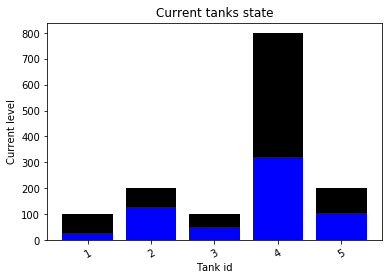

In [14]:
test_Q()
#print(np.mean(test_rewards_list) )

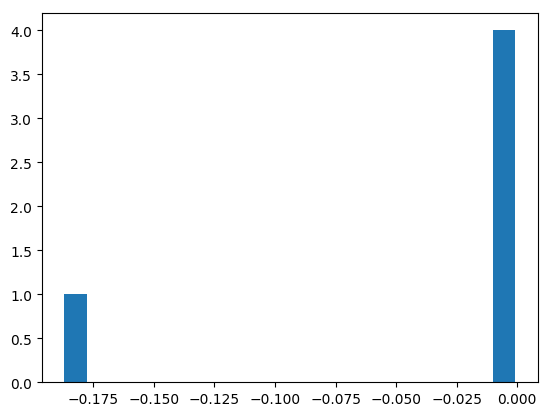

In [15]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [16]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


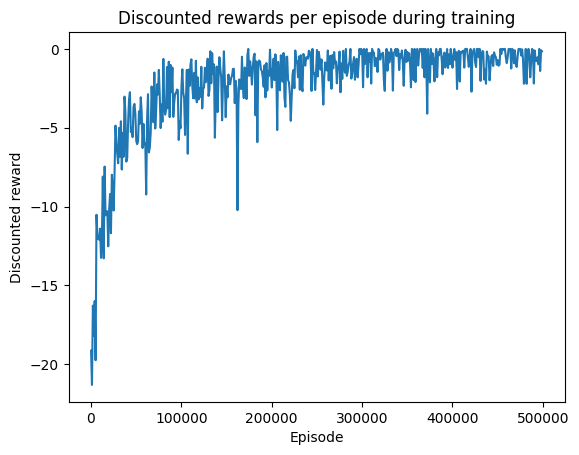

In [21]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [13]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [18]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )

    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -1076.6125344 -502.4047044 574.20783 1500
Episode 1 t 2 -1337.1705703 -290.9050903 1046.26548 5400
Episode 1 t 3 -87.8969394 27.6669006 115.56384 0500
Episode 1 t 4 -560.9495289 24.0924111 585.04194 2500
Episode 1 t 5 -535.875272 27.498448 563.37372 4500
Episode 1 t 6 -712.8227417 -149.4490217 563.37372 4500
Episode 1 t 7 -1768.5784637 -722.3129837 1046.26548 5300
Episode 1 t 8 -1134.8643281 26.9649919 1161.82932 0300
Episode 1 t 9 -539.7594479 23.6142721 563.37372 4500
Episode 1 t 10 -1630.5633005 -20.9241005 1609.6392 3300
Episode 1 t 11 -2732.1627081 -1100.8552881 1631.30742 2300
Episode 1 t 12 -1120.7384755 41.0908445 1161.82932 0400
Episode 1 t 13 -1575.7760849 33.8631151 1609.6392 3300
Episode 1 t 14 -533.9560155 29.4177045 563.37372 4500
Episode 1 t 15 -2053.7466271 -444.1074271 1609.6392 3300
Episode 1 t 16 -88.6826229 26.8812171 115.56384 0500
Episode 1 t 17 -2234.5562177 -603.2487977 1631.30742 2

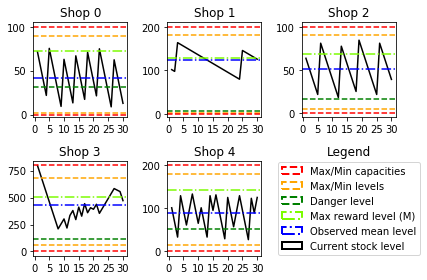

Total discounted rewards Level rewards Transport rewards
-10570.972968326367 -7210.175431220341 29407.90181999999
Average trucks sent:  43.0
Average 1st type Trucks sent to each shop: [7. 2. 4. 6. 7. 4.]
Average 1st type Trucks sent: 26.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0. 13.  4. 13.]
Average 2nd type Trucks sent: 17.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  0.  0. 30.  0.]
Average level counts for shop 3: [ 0.  0.  0. 28.  2.]
Average level counts for shop 4: [ 0.  0.  4. 26.  0.]
Average total level counts: [  0.   0.  15. 133.   2.]
Percentage total level counts: [ 0.          0.         10.         88.66666667  1.33333333]


In [19]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)


Test episode: 1
Test episode: 2
Test episode: 3
Some tank is in a forbidden level
Test episode: 4
Test episode: 5
Test episode: 6
Test episode: 7
Test episode: 8
Test episode: 9
Test episode: 10
Test episode: 11
Test episode: 12
Test episode: 13
Some tank is in a forbidden level
Test episode: 14
Test episode: 15
Test episode: 16
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 17
Some tank is in a forbidden level
Test episode: 18
Some tank is in a forbidden level
Test episode: 19
Test episode: 20
Some tank is in a forbidden level
Test episode: 21
Test episode: 22
Test episode: 23
Test episode: 24
Test episode: 25
Test episode: 26
Test episode: 27
Some tank is in a forbidden level
Test episode: 28
Test episode: 29
Test episode: 30
Test episode: 31
Test episode: 32
Test episode: 33
Test episode: 34
Test episode: 35
Test episode: 36
Test episode: 37
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 38
Some tank is in a forbi

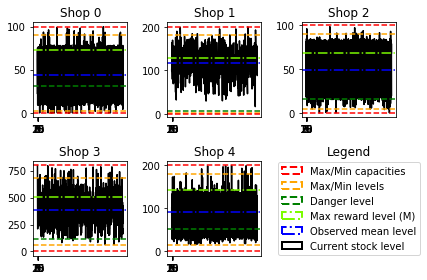

Total discounted rewards Level rewards Transport rewards
-78623.71858056208 -234031.77883679912 31048.103528400003
Average trucks sent:  44.38
Average 1st type Trucks sent to each shop: [6.74 1.19 4.37 5.24 8.3  4.16]
Average 1st type Trucks sent: 25.84
Average 2nd type Trucks sent to each shop: [ 0.    0.17  0.   15.3   3.07 11.46]
Average 2nd type Trucks sent: 18.54
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.19  0.08  9.38 20.16  0.19]
Average level counts for shop 1: [ 0.   0.   0.  29.7  0.3]
Average level counts for shop 2: [ 0.03  0.07  1.03 28.76  0.11]
Average level counts for shop 3: [ 0.    0.    0.08 29.55  0.37]
Average level counts for shop 4: [ 0.    0.    3.73 26.15  0.12]
Average total level counts: [  0.22   0.15  14.22 134.32   1.09]
Percentage total level counts: [ 0.14666667  0.1         9.48       89.54666667  0.72666667]


In [17]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)
